In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from sklearn.datasets import make_blobs
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.preprocessing import OneHotEncoder

In [0]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red", "yellow", "green"])

In [0]:
np.random.seed()

In [53]:
data, labels = make_blobs(n_samples=1000, n_features=2, centers=4, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


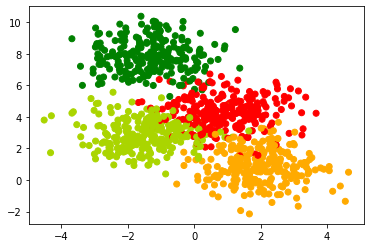

In [54]:
plt.scatter(data[:, 0], data[:, 1], c = labels, cmap = my_cmap)
plt.show()

In [0]:
W1 = np.random.randn(2, 2)
W2 = np.random.randn(2, 4)

In [56]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify = labels, random_state = 0)
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

(750, 2) (250, 2) (750,) (250,)


In [57]:
enc = OneHotEncoder()
Y_OH_train = enc.fit_transform(np.expand_dims(Y_train, 1)).toarray()
Y_OH_val = enc.fit_transform(np.expand_dims(Y_val, 1)).toarray()
print(Y_OH_train.shape,Y_OH_val.shape)

(750, 4) (250, 4)


In [0]:
class FFN:
  def __init__(self, W1, W2, init_method = "random", activation_fun = "sigmoid", leaky_slop = 0.1):
    self.params, self.update_params, self.prev_update_params, self.gradients, self.params_h = {}, {}, {}, {}, []
    self.params["W1"] = W1.copy()
    self.params["W2"] = W2.copy()
    self.params["B1"] = np.zeros((1, 2))
    self.params["B2"] = np.zeros((1, 4))
    self.activation_fun = activation_fun
    self.leaky_slop = leaky_slop
    self.nh = 2
    self.layers = [2, 2, 4]
    np.random.seed(0)
    if init_method == "zeros":
      for i in range(1, self.nh+1):
        self.params["W"+str(i)] = np.zeros((self.layers[i-1], self.layes[i]))
        self.params["B"+str(i)] = np.zeros((1, self.layes[i]))

    elif init_method == "random":
      for i in range(1, self.nh+1):
        self.params["W"+str(i)] = np.random.randn(self.layers[i-1], self.layes[i])
        self.params["B"+str(i)] = np.random.randn(1, self.layes[i])

    elif init_method == "Xavier":
      for i in range(1, self.nh+1):
        self.params["W"+str(i)] = np.random.randn(self.layers[i-1], self.layers[i]) / (np.sqrt(self.layers[i-1]))
        self.params["B"+str(i)] = np.random.randn(1, self.layers[i])

    elif init_method == "He":
      for i in range(1, self.nh+1):
        self.params["W"+str(i)] = np.random.randn(self.layers[i-1], self.layers[i]) * (np.sqrt(2 / self.layers[i-1]))
        self.params["B"+str(i)] = np.random.randn(1, self.layers[i])

    for i in range(1, self.nh+1):
      self.update_params["v_w"+str(i)] = 0
      self.update_params["v_b"+str(i)] = 0
      self.update_params["m_w"+str(i)] = 0
      self.update_params["m_b"+str(i)] = 0
      self.prev_update_params["v_w"+str(i)] = 0
      self.prev_update_params["v_b"+str(i)] = 0

  def forward_activation(self, X):
    if self.activation_fun == "sigmoid":
      return 1. / (1. + np.exp(-X))
    elif self.activation_fun == "tanh":
      return np.tanh(X)
    elif self.activation_fun == "relu":
      return np.maximum(0, X)
    elif self.activation_fun == "Leaky_relu":
      return np.maximum(self.leaky_slop * X, X)
  
  def grad_activation(self, X):
    if self.activation_fun == "sigmoid":
      return X * (1-X)
    elif self.activation_fun == "tanh":
      return (1-np.square(X))
    elif self.activation_fun == "relu":
      return 1 * (X > 0)
    elif self.activation_fun == "Leaky_relu":
      d = np.zeros_like(X)
      d[X<=0] = self.leaky_slop
      d[X>0] = 1
      return d
  
  def softmax(self, X):
    exps = np.exp(X)
    return exps / np.sum(exps, axis = 1).reshape(-1, 1)

  def forward_pass(self, X, params = None):
    if params == None:
      params = self.params
    self.A1 = np.matmul(X, self.params["W1"]) + self.params["B1"]    # (N, 2) * (2, 2) -> (N, 2)
    self.H1 = self.forward_activation(self.A1)        # (N, 2)
    self.A2 = np.matmul(self.H1, self.params["W2"]) + self.params["B2"]       # (N, 2) * (2, 4) -> (N, 4)
    self.H2 = self.softmax(self.A2)         # (N, 4)
    return self.H2

  def grad(self, X, Y, params = None):
    if params == None:
      params = self.params
    self.forward_pass(X, params)
    self.gradients["dA2"] = self.H2 - Y   # (N, 4) - (N, 4) -> (N, 4)
    self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"])       # (2, N) * (N, 4) -> (2, 4)
    self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis = 0).reshape(1, -1)      # (1, 4)
    self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T)     # (N, 4) * (4, 2) -> (N, 2)
    self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1))   # (N, 2) * (N, 2) -> (N, 2)
    self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"])       # (2, N) * (N, 2) -> (2, 2)
    self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis = 0).reshape(1, -1)      # (1, 2)

  def fit(self, X, Y, algo = 'GD', eta= 1, epochs = 100, gamma = .7, beta=.9, beta1=.9, beta2=.9, eps = 1e-8, batch_size = 64):
    loss = {}
    for epoch in tqdm_notebook(range(epochs), total = epochs, unit = "epoch"):
      m = X.shape[0]
      if algo == 'GD':
        self.grad(X, Y)
        for i in range(1, self.nh+1):
          self.params["W"+str(i)] -= eta * self.gradients["dW"+str(i)] / m
          self.params["B"+str(i)] -= eta * self.gradients["dB"+str(i)] / m
      
      elif algo == 'Momentum':
        self.grad(X, Y)
        for i in range(1, self.nh+1):
          self.update_params["v_w"+str(i)] = gamma * self.update_params["v_w"+str(i)] + eta * self.gradients["dW"+str(i)] / m
          self.update_params["v_b"+str(i)] = gamma * self.update_params["v_b"+str(i)] + eta * self.gradients["dB"+str(i)] / m
          self.params["W"+str(i)] -= self.update_params["v_w"+str(i)]
          self.params["B"+str(i)] -= self.update_params["v_b"+str(i)]
      
      elif algo == 'NAG':
        temp_params = {}
        for i in range(1, self.nh+1):
          self.update_params["v_w"+str(i)] = gamma * self.prev_update_params["v_w"+str(i)]
          self.update_params["v_b"+str(i)] = gamma * self.prev_update_params["v_b"+str(i)]
          temp_params["W"+str(i)] = self.params["W"+str(i)] - self.update_params["v_w"+str(i)]
          temp_params["B"+str(i)] = self.params["B"+str(i)] - self.update_params["v_b"+str(i)]
        self.grad(X, Y, temp_params)
        for i in range(1, self.nh+1):
          self.update_params["v_w"+str(i)] += eta * self.gradients["dW"+str(i)] / m
          self.update_params["v_b"+str(i)] += eta * self.gradients["dB"+str(i)] / m
          self.params["W"+str(i)] -= self.update_params["v_w"+str(i)]
          self.params["B"+str(i)] -= self.update_params["v_b"+str(i)]
        self.prev_update_params = self.update_params
      
      elif algo == 'Adagrad':
        self.grad(X, Y)
        for i in range(1, self.nh+1):
          self.update_params["v_w"+str(i)] += ((self.gradients["dW"+str(i)]) **2)
          self.update_params["v_b"+str(i)] += ((self.gradients["dB"+str(i)]) **2)
          self.params["W"+str(i)] -= (eta / (np.sqrt(self.update_params["v_w"+str(i)])+eps)) * (self.gradients["dW"+str(i)] / m)
          self.params["B"+str(i)] -= (eta / (np.sqrt(self.update_params["v_b"+str(i)])+eps)) * (self.gradients["dB"+str(i)] / m)

      elif algo == "RMSprop":
        self.grad(X, Y)
        for i in range(1, self.nh+1):
          self.update_params["v_w"+str(i)] = beta * self.update_params["v_w"+str(i)] + (1 - beta) * ((self.gradients["dW"+str(i)]) **2)
          self.update_params["v_b"+str(i)] = beta * self.update_params["v_b"+str(i)] + (1 - beta) * ((self.gradients["dB"+str(i)]) **2)
          self.params["W"+str(i)] -= (eta / (np.sqrt(self.update_params["v_w"+str(i)]+eps))) * self.gradients["dW"+str(i)] / m
          self.params["B"+str(i)] -= (eta / (np.sqrt(self.update_params["v_b"+str(i)]+eps))) * self.gradients["dB"+str(i)] / m

      elif algo == "Adam":
        self.grad(X, Y)
        no_updates = 0
        for i in range(1, self.nh+1):
          no_updates += 1
          self.update_params["v_w"+str(i)] = beta2 * self.update_params["v_w"+str(i)] + (1 - beta2) * (self.gradients["dW"+str(i)] / m) **2
          self.update_params["m_w"+str(i)] = beta1 * self.update_params["m_w"+str(i)] + (1-beta1) * (self.gradients["dW"+str(i)] / m)
          m_w_hat = self.update_params["m_w"+str(i)] / (1-np.power(beta1, no_updates))
          v_w_hat = self.update_params["v_w"+str(i)] / (1-np.power(beta2, no_updates))
          self.params["W"+str(i)] -= (eta / (np.sqrt(v_w_hat + eps))) * m_w_hat
          
          self.update_params["v_b"+str(i)] = beta2 * self.update_params["v_b"+str(i)] + (1 - beta2) * (self.gradients["dB"+str(i)] / m) **2
          self.update_params["m_b"+str(i)] = beta1 * self.update_params["m_b"+str(i)] + (1-beta1) * (self.gradients["dB"+str(i)] / m)
          m_b_hat = self.update_params["m_b"+str(i)] / (1-np.power(beta1, no_updates))
          v_b_hat = self.update_params["v_b"+str(i)] / (1-np.power(beta2, no_updates))
          self.params["B"+str(i)] -= (eta / (np.sqrt(v_b_hat + eps))) * m_b_hat
          
      elif algo == 'mini_batch':
        for k in range(0, m, batch_size):
          self.grad(X[k:k+batch_size], Y[k:k+batch_size])
          for i in range(1, self.nh+1):
            self.params["W"+str(i)] -= eta * self.gradients["dW"+str(i)] / batch_size
            self.params["B"+str(i)] -= eta * self.gradients["dB"+str(i)] / batch_size
      
      Y_pred = self.predict(X)
      loss[epoch] = log_loss(np.argmax(Y, 1), Y_pred)       # Doubt
      self.params_h.append(np.concatenate((self.params["W1"].ravel(), self.params["W2"].ravel(), self.params["B1"].ravel(), self.params["B2"].ravel())))

    plt.plot(list(loss.values()), '-o', markersize=5)
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.show()
  
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()

In [0]:
def print_accuracy(plot_scale = 0.1):
  Y_pred_train = ffn.predict(X_train)
  Y_pred_train = np.argmax(Y_pred_train, axis = 1)
  Y_pred_val = ffn.predict(X_val)
  Y_pred_val = np.argmax(Y_pred_val, axis = 1)
  print(accuracy_score(Y_pred_train, Y_train))
  print(accuracy_score(Y_pred_train, Y_train))

  plt.scatter(X_train[:, 0], X_train[:, 1], c = Y_pred_train, cmap = my_cmap, s = 15 * (np.abs(np.sign(Y_pred_train - Y_train))+.1))
  plt.show()

  h = np.asarray(ffn.params_h)
  h_diff = (h[0:-1, :] - h[1:, :])
  for i in range(18):
    plt.subplot(6, 3, i+1)
    plt.plot(h_diff[:, i], '-')
    plt.ylim((-plot_scale, plot_scale))
    plt.yticks([])
    plt.xticks([])
  plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:91: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


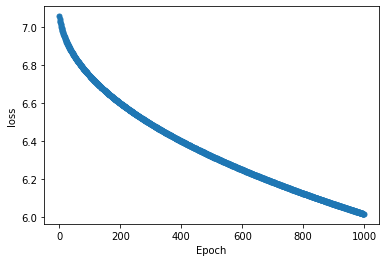

0.076
0.076


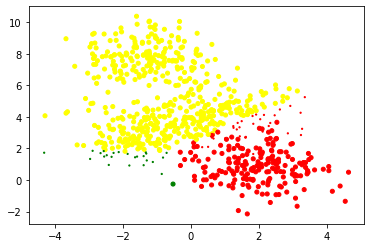

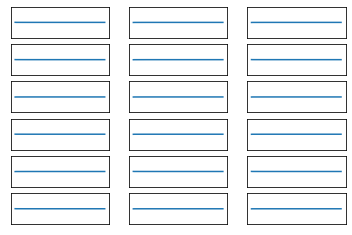

In [108]:
ffn = FFN(W1, W2, init_method="He", activation_fun = "Leaky_relu")
ffn.fit(X_train, Y_OH_train, epochs = 1000, eta=.5, algo = 'Adagrad', gamma = .9,batch_size = 128, beta = 0.7, beta1=.9, beta2 = 0.9)
print_accuracy()